<a href="https://colab.research.google.com/github/woogi123/CIFAKE_Image_audit/blob/main/FakeCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 세팅

dataset: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

참조 (CIFAKE): https://www.youtube.com/watch?v=yf3rcJQG2Bg

In [1]:
import os
import shutil
from google.colab import userdata
from IPython.display import clear_output

# 1. Kaggle 인증 설정
os.environ['KAGGLE_USERNAME'] = userdata.get('auditAPI')
os.environ['KAGGLE_KEY'] = userdata.get('auditAPI_KEY')

# 2. 초기화
data_dir = '/content/cifake'
zip_file = 'cifake-real-and-ai-generated-synthetic-images.zip'

# 기존 압축 파일이 있다면 삭제
if os.path.exists(zip_file):
    os.remove(zip_file)
    print(f"Deleted existing zip file: {zip_file}")

# 기존 데이터 폴더가 있다면 전체 삭제 (초기화)
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
    print(f"Deleted existing directory: {data_dir}")

# 3. 데이터셋 다운로드 및 압축 해제
print("Downloading dataset...")
!pip install -q Kaggle
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

print("Unzipping dataset...")
!unzip -q {zip_file} -d {data_dir}

# 4. 결과 정리
clear_output()
print('Kaggle Authentication and Dataset Setup Successful.')
print(f'Data is ready at: {data_dir}')

Kaggle Authentication and Dataset Setup Successful.
Data is ready at: /content/cifake


## Data Extraction and Cleanup
real, fake 별로 10000장씩 꺼내서 validation set을 구성


In [2]:
import os
import random
import shutil

DATA_ROOT = '/content/cifake'
train_path = os.path.join(DATA_ROOT, 'train')
validation_path = os.path.join(DATA_ROOT, 'validation')

VALIDATION_SAMPLE_PER_CLASS = 10000

# Create Validation Folders
os.makedirs(os.path.join(validation_path, 'REAL'), exist_ok=True)
os.makedirs(os.path.join(validation_path, 'FAKE'), exist_ok=True)

# REAL
real_train_source = os.path.join(train_path, 'REAL')
real_validation_dest = os.path.join(validation_path, 'REAL')

real_images = os.listdir(real_train_source)
random.shuffle(real_images)

images_to_move_real = real_images[:VALIDATION_SAMPLE_PER_CLASS]

for image in images_to_move_real:
    shutil.move(
        os.path.join(real_train_source, image),
        os.path.join(real_validation_dest, image)
    )
print('Finish Validation set ( Real )')

# FAKE
fake_train_source = os.path.join(train_path, 'FAKE')
fake_validation_dest = os.path.join(validation_path, 'FAKE')

fake_images = os.listdir(fake_train_source)
random.shuffle(fake_images)

images_to_move_fake = fake_images[:VALIDATION_SAMPLE_PER_CLASS]

for image in images_to_move_fake:
    shutil.move(
        os.path.join(fake_train_source, image),
        os.path.join(fake_validation_dest, image)
    )
print('Finish Validation set ( Fake )')

# Re-count files in directories
new_train_real_count = len(os.listdir(real_train_source))
new_train_fake_count = len(os.listdir(fake_train_source))
var_real_count = len(os.listdir(real_validation_dest))
var_fake_count = len(os.listdir(fake_validation_dest))

print('\nChecking...\n')
test_path = os.path.join(DATA_ROOT, 'test')
test_real_count = len(os.listdir(os.path.join(test_path, 'REAL')))
test_fake_count = len(os.listdir(os.path.join(test_path, "FAKE")))

print(f'Train (Real): {new_train_real_count}')
print(f'Train (Fake): {new_train_fake_count}')
print(f'\nValidation (Real): {var_real_count}')
print(f'Validation (Fake): {var_fake_count}')
print(f'\nTest (Real): {test_real_count}')
print(f'Test (Fake): {test_fake_count}')

Finish Validation set ( Real )
Finish Validation set ( Fake )

Checking...

Train (Real): 40000
Train (Fake): 40000

Validation (Real): 10000
Validation (Fake): 10000

Test (Real): 10000
Test (Fake): 10000


### Visualize Images
- 사전 데이터 탐색 (랜덤으로 fake 4, real 4)


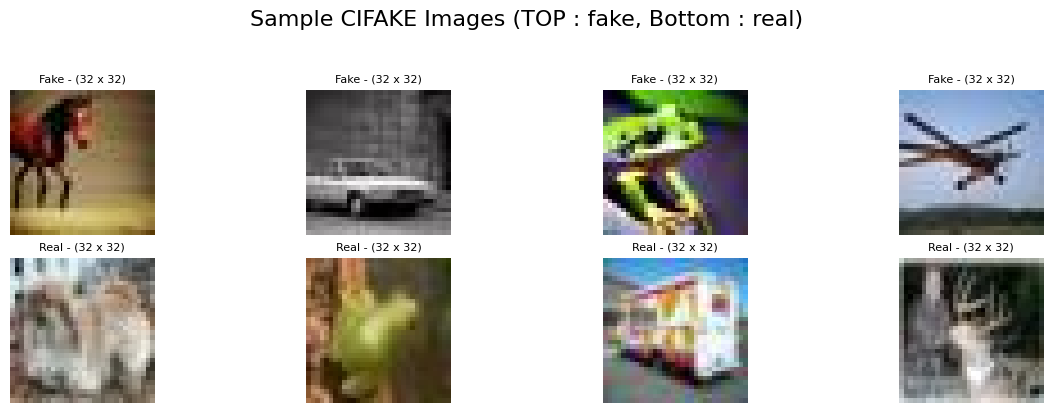

In [6]:
import matplotlib.pyplot as plt
import random
from PIL import Image

TRAIN_FAKE_DIR = os.path.join(DATA_ROOT, 'train/FAKE')
TRAIN_REAL_DIR = os.path.join(DATA_ROOT, 'train/REAL')

fake_files = os.listdir(TRAIN_FAKE_DIR)
real_files = os.listdir(TRAIN_REAL_DIR)

# 랜덤으로image 보여주기
num_samples = 8
random_fake = random.sample(fake_files, num_samples // 2)
random_real = random.sample(real_files, num_samples // 2)

fig, axes = plt.subplots(2, num_samples // 2, figsize=(12, 6))
fig.suptitle('Sample CIFAKE Images (TOP : fake, Bottom : real)', fontsize=16)

# Display Fake Image
for i, filename in enumerate(random_fake):
  img_path = os.path.join(TRAIN_FAKE_DIR, filename)
  img = Image.open(img_path)
  axes[0, i].imshow(img)
  axes[0, i].set_title(f'Fake - ({img.size[0]} x {img.size[1]})', fontsize = 8)
  axes[0, i].axis('off')

# Display Real Image
for i, filename in enumerate(random_real):
  img_path = os.path.join(TRAIN_REAL_DIR, filename)
  img = Image.open(img_path)
  axes[1, i].imshow(img)
  axes[1, i].set_title(f'Real - ({img.size[0]} x {img.size[1]})', fontsize = 8)
  axes[1, i].axis('off')

plt.tight_layout(rect = [0,0.3,1,0.95])
plt.show()

### Data Loading with Keras

#### Keras
- 사용: add()로 입력층, 은닉층, 출력층을 만들기 매우 쉬움
- Ex. model.add(tf.keras.layers.Dense(64, activation='relu'))

- build -> Compile -> Fit 과정으로 구현
- ! 현재는 TensorFlow에 흡수됨

In [9]:
import tensorflow as tf
import os

# DATASET CONFIG PARAMETERS
IMG_SIZE = 32
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
DATA_ROOT = '/content/cifake'

# DIRECTORY PATHS
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VALIDATION_DIR = os.path.join(DATA_ROOT, 'validation')
TEST_DIR = os.path.join(DATA_ROOT, 'test')

# Load training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
      TRAIN_DIR,
      label_mode = 'binary',
      # fake, real을 0과 1로 구분 (3개 이상일 땐 int로 0, 1, 2로 구분 가능)
      seed = SEED,
      # 랜덤 시드값 고정
      image_size = (IMG_SIZE, IMG_SIZE),
      batch_size = BATCH_SIZE,
      shuffle = True
)

# tf.keras.utils.image_dataset_from_directory:
# -> Directory 들어가서 내부 폴더 라벨 매김 -> 파일 읽어서 RGB로 바꾸고, batch_size만큼씩 묶어서 라벨 매긴 폴더에 저장

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
      VALIDATION_DIR,
      label_mode = 'binary',
      seed = SEED,
      image_size = (IMG_SIZE, IMG_SIZE),
      batch_size = BATCH_SIZE,
      shuffle = False
)

# Load Test Data
test_ds = tf.keras.utils.image_dataset_from_directory(
      TEST_DIR,
      label_mode = 'binary',
      seed = SEED,
      image_size = (IMG_SIZE, IMG_SIZE),
      batch_size = BATCH_SIZE,
      shuffle = False
)

# Nomalize and AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# print
print('Dataset 준비완료')

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Dataset 준비완료


### CNN Architecture

In [12]:
from tensorflow import keras
from tensorflow.keras import layers


# Define the CNN architecture
inputs = keras.Input(shape = (32, 32, 3)) # (image size, image_size, R.G.B)(keras의 Default value임)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

# model 생성
model = keras.Model(inputs = inputs, outputs = outputs)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,001 (328.13 KB)

 Trainable params: 84,001 (328.13 KB)

 Non-trainable params: 0 (0.00 B)